# **Predicción de acciones en la bolsa con Python y Keras (Redes LSTM)**





## **Notebook- Tredicción de acciones en la bolsa con Python y Keras y Dataset "Acciones de Apple"**

# **OBJETIVO GENERAL:**

-  Desarrollar un ejemplo de una Red Neuronal Recurrente (RNN) de tipo LSTM , utilizando Python y TensorFlow/Keras. que permita entrenar una LSTM en Python y Keras y sea capaz de predecir el valor que tendrá en el futuro una acción en la bolsa de valores.

***- ACTIVIDADES DE APRENDIZAJE:***

1.	Visualizar el comportamiento histórico de la acción de Apple en los últimos años.
2. Diseñar y entrenar una en Python y Keras, la cual tomará estos datos históricos y permitirá generar una predicción.

***- CONTENIDO:***

1. Introducción
2. El set de datos
3. Pre-procesamiento de los datos
4. Creación de los sets de entrenamiento y validación
Normalización de los datos
5. Ajuste de los sets de entrenamiento y validación
6. Creación y entrenamiento de la Red LSTM
7. Implementación del modelo en Keras
8. Predicción del valor de la acción
9. Conclusión






***Ref:***
- Predicción de acciones en la bolsa con PYTHON (tutorial redes LSTM). https://www.youtube.com/watch?v=3kXj6VgxbP8

# **1. INTRODUCCIÓN**

#SET DE DATOS

- El set de datos contiene registros diarios de la variación de la acción de Apple entre el año 2006 y 2017. El modelo se implementa en Keras usando la función LSTM.
- Tras 20 iteraciones de entrenamiento se obtiene una predicción bastante cercana al valor real, con una diferencia que en la mayoría de los casos no supera los 10 dólares.

In [ ]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()


**NOTAS:**

- El Dataset se lee fácilmente usando la librería Pandas de Python,
- Al visualizar el contenido de este Dataset se observa que cada registro contiene la información de los valores más altos y más bajos alcanzados por la acción, así como los valores de apertura y cierre y el volumen de las transacciones.
-  Para el entrenamiento de la Red LSTM se usando únicamente el valor más alto de la acción (columna High en el set de datos).

In [ ]:
#
# Lectura de los datos
#
dataset = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


# **2. PREPROCESAMIENTO DE LOS DATOS**

# Creación de los sets de entrenamiento y validación

- Para el entrenamiento de la Red LSTM se usan los datos entre Enero de 2006 y Diciembre de 2016, mientras que para la validación y la predicción se usan todos los registros del año 2017.
- La idea es que la Red LSTM aprenda a predecir los valores máximos de la acción para el año 2017, usando el comportamiento en años anteriores.


- EJEMPLO de la forma como estarán distribuidos los sets de entrenamiento y validación:

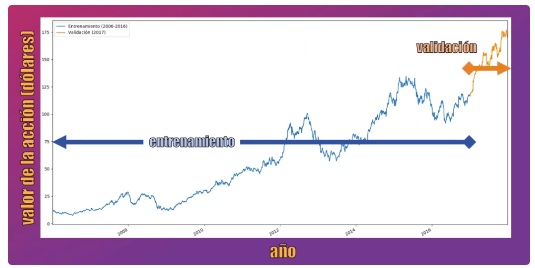

- Teniendo lo anterior en cuenta, la creación de los sets de entrenamiento y validación se efectúa por medio de la función **iloc** de Pandas, en donde **.iloc[:,1:2] ** permite seleccionar únicamente la columna High del dataset.

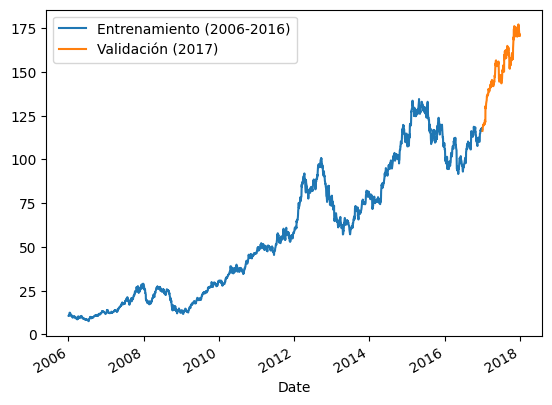

In [ ]:
#
# Sets de entrenamiento y validación
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset[:'2016'].iloc[:,1:2]
set_validacion = dataset['2017':].iloc[:,1:2]

set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

# **3. Normalización de los datos**

# Anáisis del comportamiento de la acción

- Si se analiza el comportamiento de la acción de Apple en los últimos años se observa, en la siguiente figura, que tiene una tendencia creciente:

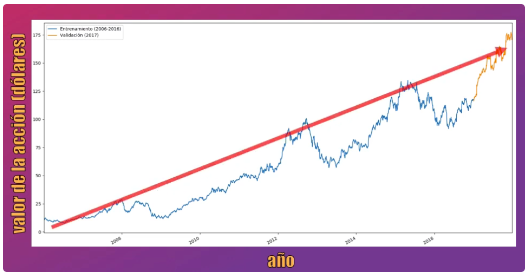

- Para que la Red LSTM pueda ser entrenada, se debe garantizar que los valores de la acción se encuentren en un rango definido.
- Se usa la librería Scikit-learn para normalizar estos valores en el rango de 0 a 1, usando la función MinMaxScaler.
- Una vez realizado el entrenamiento, al momento de la predicción, se raliza la transformación inversa para obtener los valores en la escala real.

# Ajuste de los sets de entrenamiento y validación

- Para entrenar la Red LSTM se consideran bloques de 60 datos consecutivos, y la idea es que cada uno de estos permita predecir el siguiente valor.
- Los bloques de 60 datos serán almacenados en la variable X, mientras que el dato que se debe predecir (el dato 61 dentro de cada secuencia) se almacenará en la variable Y y será usado como la salida de la Red LSTM.

In [ ]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [ ]:
#
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)


- En el código anterior se usa el bloque **for** para iterativamente dividir el set de entrenamiento en bloques de 60 datos y almacenar los bloques correspondientes en diferentes posiciones de las variables X_train y Y_train.
- Antes de crear la Red LSTM se debe reajustar los sets que acabamos de obtener, para indicar que cada ejemplo de entrenamiento a la entrada del modelo será un vector de 60x1. Para lo anterior se utiliza la función **reshape** de Numpy.
- Para el caso de cada una de las salidas (almacenadas en Y_train) se debe simplemente especificar que su tamaño será igual a 1, que corresponde al único valor predicho por la red.

# **4. Creación y entrenamiento de la Red LSTM**

# Implementación del modelo en Keras

- Para implementar el modelo se debe primero importar las librerías de Keras correspondientes a las Redes LSTM. Usaremos el módulo Sequential para crear el contenedor, al cual iremos añadiendo la Red LSTM (usando el módulo LSTM) y la capa de salida (usando el módulo Dense). Esto se encuentra implementado al inicio del caso de uso.
- Para crear la red se debe primero definir el tamaño de los datos de entrada y del dato de salida, así como el número total de neuronas (50):
- Como fue mencionado anteriormente, para crear la Red LSTM debe primero crear un contenedor usando el módulo Sequential.
- Posteriormente se añade la Red LSTM usando la función **add**, especificando el número de neuronas a usar (parámetro units) y el tamaño de cada dato de entrada (parámetro **input_shape**).
- Para la capa de salida se usa la función **Dense** y especificamos que el dato de salida tendrá un tamaño igual a 1 (parámetro **units**):
- Luego se debe compilar el modelo, definiendo así la función de error (parámetro **loss**) así como el método que se usará para minimizarla (parámetro **optimizer**).
- El optimizador seleccionado (**rmsprop**) funciona de manera similar al algoritmo del Gradiente Descendente (ver https://www.codificandobits.com/blog/el-gradiente-descendente/ ), mientras que la función de error es el error cuadrático medio (ver https://www.codificandobits.com/blog/regresion-lineal/ ).  
- El entrenamiento se implementa de forma sencilla usando la función **fit**. En este caso usaremos un total de 20 iteraciones (parámetro **epochs**) y se presenta a la Red LSTM lotes de 32 datos (parámetro **batch_size**):

In [ ]:
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')



In [ ]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


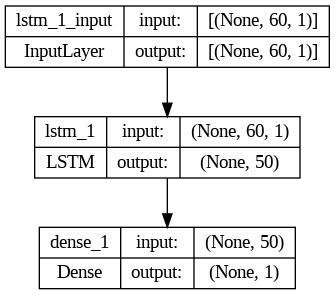

In [ ]:
 from keras.utils import plot_model

# Visualización de la red (Modelo), y se guarda el gráfico resultante en disco, en el archivo net.png:
plot_model(modelo, 'net.png', show_shapes=True)

In [ ]:
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
85/85 [==============================] - 5s 28ms/step - loss: 0.0064
Epoch 2/20
85/85 [==============================] - 2s 29ms/step - loss: 9.1657e-04
Epoch 3/20
85/85 [==============================] - 2s 29ms/step - loss: 7.1903e-04
Epoch 4/20
85/85 [==============================] - 4s 43ms/step - loss: 5.6946e-04
Epoch 5/20
85/85 [==============================] - 2s 29ms/step - loss: 4.9280e-04
Epoch 6/20
85/85 [==============================] - 3s 30ms/step - loss: 4.3508e-04
Epoch 7/20
85/85 [==============================] - 2s 29ms/step - loss: 3.9855e-04
Epoch 8/20
85/85 [==============================] - 3s 33ms/step - loss: 3.7238e-04
Epoch 9/20
85/85 [==============================] - 3s 40ms/step - loss: 3.6120e-04
Epoch 10/20
85/85 [==============================] - 3s 29ms/step - loss: 3.5075e-04
Epoch 11/20
85/85 [==============================] - 3s 30ms/step - loss: 3.2236e-04
Epoch 12/20
85/85 [==============================] - 2s 29ms/step - loss: 2.89

# Predicción del valor de la acción

- Con el modelo entrenado, se debe determinar que tan bien predice la Red LSTM los valores de la acción de Apple.
- Inicialmente se debe preparar el set de validación, normalizando inicialmente los datos, en el rango de 0 a 1, para lo cual se usa la transformación implementada anteriormente sobre el set de entrenamiento.
- Debe recordarse que el modelo fue entrenado para tomar 60 y generar un dato como predicción. Así que se debe reorganizar el set de validación (x_test) para que tenga bloques de 60 datos.
- Finalmente se realiza la predicción usando la función **predict** y se aplica la normalización inversa de dicha predicción para que esté en la escala real de las acciones.

In [ ]:

#
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


6/6 [==============================] - 1s 15ms/step


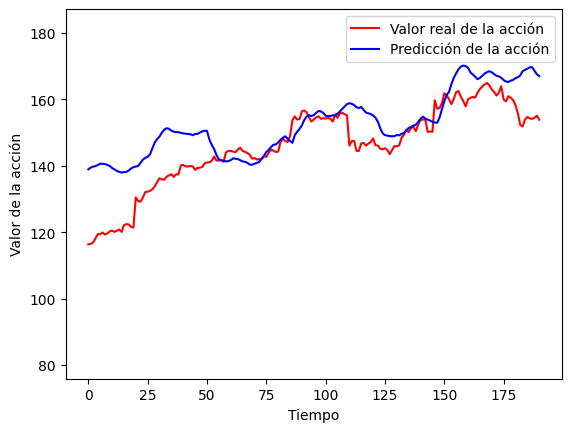

In [ ]:
#
# Graficar resultados

graficar_predicciones(set_validacion.values,prediccion)

# **5. CONCLUSIÓN**



1. Al ejecutar este código se observa que la red logra predecir bastante bien los valores máximos de la acción de Apple, pues para la mayor parte de los datos predichos la diferencia es igual o menor a los 10 dólares con respecto al valor real.


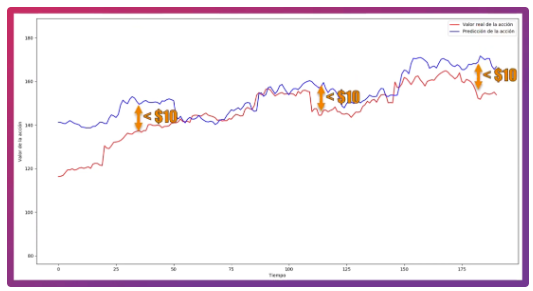

2. La implementación del modelo logró implementar de manera sencilla una Red LSTM capaz de predecir de forma bastante aproximada el comportamiento de una acción en la bolsa de valores.
3. Debe considerarse que la implementación realizada se un modelo preliminar que puede ser mejorado, por ejemplo agregando más capas LSTM y/o modificando el número de neuronas en cada una de las capas.